In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dash import Dash, html, dash_table, dcc, Output, Input

Import data

In [2]:
pp_db_raw = pd.read_csv("global_power_plant_database.csv", dtype={'other_fuel3': str})
cont = pd.read_csv("list-of-countries-by-continent-2024.csv")

Check columns and merge on country_long and country column

In [3]:

print("Before merge", pp_db_raw.shape)
print("Power Plant DB columns: ", pp_db_raw.columns)
print("Country & Continent CSV file columns: ", cont.columns)
pp_db = pp_db_raw.merge(cont, how='left', left_on='country_long', right_on='country', suffixes=('_short', ''))
print("After merge", pp_db.shape) # 3 columns added and same number of rows due to left join


Before merge (34936, 36)
Power Plant DB columns:  Index(['country', 'country_long', 'name', 'gppd_idnr', 'capacity_mw',
       'latitude', 'longitude', 'primary_fuel', 'other_fuel1', 'other_fuel2',
       'other_fuel3', 'commissioning_year', 'owner', 'source', 'url',
       'geolocation_source', 'wepp_id', 'year_of_capacity_data',
       'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
       'generation_gwh_2016', 'generation_gwh_2017', 'generation_gwh_2018',
       'generation_gwh_2019', 'generation_data_source',
       'estimated_generation_gwh_2013', 'estimated_generation_gwh_2014',
       'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016',
       'estimated_generation_gwh_2017', 'estimated_generation_note_2013',
       'estimated_generation_note_2014', 'estimated_generation_note_2015',
       'estimated_generation_note_2016', 'estimated_generation_note_2017'],
      dtype='object')
Country & Continent CSV file columns:  Index(['country', 'continen

Check records missing country field to see if merge was successful

In [4]:

print(pp_db[['country_short', 'country_long', 'country', 'continent']].isna().sum())  
# country column in merged table has 73 missing values, we check which records these correspond to in raw table
print(pp_db_raw[pp_db['country'].isna()]['country_long'].unique())
# Note that 2 power plants are located in Antarctica which we add to Oceania (New Zealand)
print("Antarctica Power Plants: ", pp_db.loc[pp_db['country_long']=='Antarctica', :'primary_fuel'])

country_short     0
country_long      0
country          73
continent        73
dtype: int64
['Antarctica' 'Brunei Darussalam' 'Congo' 'Cote DIvoire'
 'Democratic Republic of the Congo' 'Macedonia' 'Swaziland'
 'Syrian Arab Republic']
Antarctica Power Plants:     country_short country_long                       name   gppd_idnr  \
90           ATA   Antarctica  McMurdo Station Generator  WRI1023843   
91           ATA   Antarctica                Ross Island  WRI1022458   

    capacity_mw  latitude  longitude primary_fuel  
90          6.6  -77.8470   166.6605          Oil  
91          1.0  -77.8428   166.7271         Wind  



Comparing output to list-of-countries-by-continent-2024.csv , we make the following changes manually:

Swaziland --> Eswatini, Brunei Darussalam --> Brunei

Congo --> Republic of the Congo, Cote DIvoire --> Ivory Coast

Democratic Republic of the Congo --> DR Congo, Macedonia --> North Macedonia

Syrian Arab Republic --> Syria

We also  make these changes to the raw data in the continent CSV file:

Add Kosovo, United States --> United States of America

Antarctica --> New Zealand


In [5]:
replacement_dict={
    'Swaziland': 'Eswatini',
    'Brunei Darussalam': 'Brunei',
    'Congo': 'Republic of the Congo',
    'Cote DIvoire': 'Ivory Coast',
    'Democratic Republic of the Congo': 'DR Congo',
    'Macedonia': 'North Macedonia',
    'Syrian Arab Republic': 'Syria',
    'Antarctica': 'New Zealand'
}
pp_db_raw['country_long'] = pp_db_raw['country_long'].replace(replacement_dict)

pp_db = pp_db_raw.merge(cont, how='left', left_on='country_long', right_on='country', suffixes=('_short', ''))

print(pp_db[['country_short', 'country_long', 'country', 'continent']].isna().sum())

country_short    0
country_long     0
country          0
continent        0
dtype: int64


continent
Africa           552.336990
Asia             745.625443
Europe           354.648059
North America    349.916938
Oceania          281.311794
South America    374.340956
Name: capacity_mw, dtype: float64


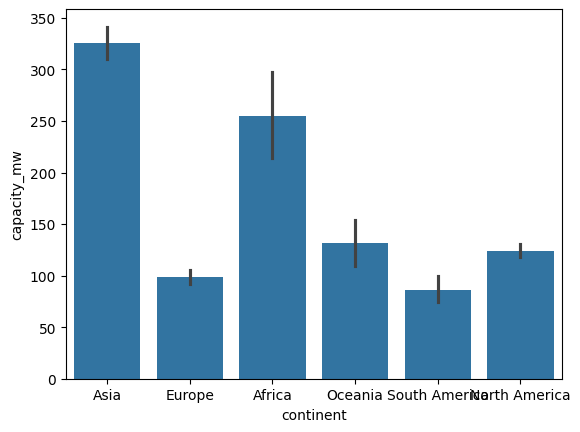

In [6]:
value_vars= ["estimated_generation_gwh_" + str(int(i)) for i in np.linspace(2013, 2017, 5)]
print(pp_db.groupby('continent')['capacity_mw'].std())
sns.barplot(data=pp_db, x='continent', y='capacity_mw')
plt.show()

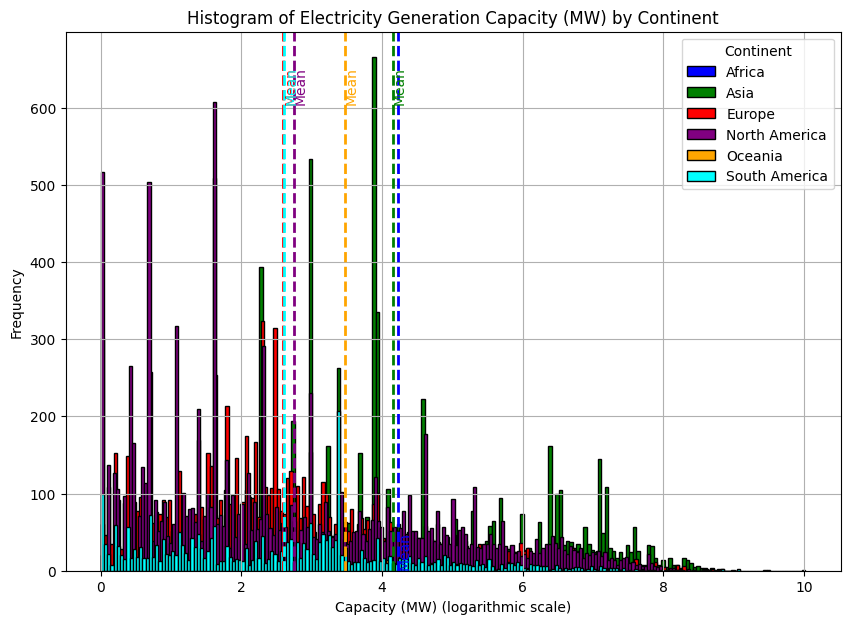

[1.00e+00 7.00e+00 4.60e+01 2.25e+04]
capacity_type
Low (1MW-7MW)          11800
High (46MW-22500MW)    11645
Medium (7MW-46MW)      11491
Name: count, dtype: int64


In [7]:
group_by_cont = pp_db.groupby('continent')['capacity_mw']
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'brown']

for (continent, data), color in zip(group_by_cont, colors):
    plt.hist(np.log(data), bins=200, alpha=1, label=continent, color=color, edgecolor='black')
    # Calculate and plot the mean
    mean_value = np.log(data).mean()
    plt.axvline(mean_value, color=color, linestyle='dashed', linewidth=2)
    plt.text(mean_value, plt.ylim()[1]*0.9, 'Mean', color=color, rotation=90, verticalalignment='center')

# Add labels and legend
plt.title('Histogram of Electricity Generation Capacity (MW) by Continent')
plt.xlabel('Capacity (MW) (logarithmic scale)')
plt.ylabel('Frequency')
plt.legend(title='Continent')
plt.grid(True)

# Show the plot
plt.show()

pp_db['capacity_type'], bins = pd.qcut(pp_db['capacity_mw'], q=3, labels=['Low (1MW-7MW)', 'Medium (7MW-46MW)', 'High (46MW-22500MW)'], retbins=True)
print(bins)
print(pp_db['capacity_type'].value_counts())


In [11]:
pp_db['text'] = pp_db['name'] + ', ' + pp_db['country']

###### Create web app with Plotly/Dash #######

app = Dash()

custom_colors = [
    "#FF5733",  # Red-Orange
    "#33FF57",  # Green
    "#3357FF",  # Blue
    "#F39C12",  # Orange
    "#9B59B6",  # Purple
    "#E74C3C",  # Red
    "#1ABC9C",  # Teal
    "#8E44AD",  # Dark Purple
    "#3498DB",  # Light Blue
    "#2ECC71",  # Light Green
    "#E67E22",  # Dark Orange
    "#ECF0F1",  # Light Grey
    "#95A5A6",  # Grey
    "#34495E",  # Dark Blue-Grey
    "#16A085"   # Dark Teal
]

map_fig = px.scatter_geo(
    data_frame=pp_db.sort_values(by='capacity_mw', ascending=False).head(12000),
    lat='latitude',
    lon='longitude',
    color='primary_fuel',
    hover_name='text',
    color_discrete_sequence=custom_colors,
    size='capacity_mw',
    opacity=0.7,
    projection='natural earth',
    title='Global Distribution of High Capacity Power Plants'
)

# Update marker border properties
map_fig.update_traces(
    marker=dict(
        line=dict(
            color='black',  # Border color
            width=0.1  # Border width
        )
    )
)

app.layout = [
    html.Div(children='Power Plant Dataset Dashboard', style={'textAlign':'center'}),
    dash_table.DataTable(data=pp_db.sort_values('capacity_mw', ascending=False).to_dict('records'), page_size=10),
    dcc.Graph(figure=px.histogram(pp_db, x='continent', y='capacity_mw', histfunc='sum')),
    dcc.Dropdown(id='capacity_dropdown',
                 options=pp_db['continent'].unique(),
                 value='Africa'),
    dcc.Graph(id='capacity_hist'),
    dcc.Graph(figure=map_fig)]

@app.callback(Output('capacity_hist', 'figure'),
              Input('capacity_dropdown', 'value'))
def sync_input(cont_selection):
    continent_filtered = pp_db.loc[pp_db['continent'] == cont_selection].copy()
    continent_filtered.loc[:,'log_capacity_mw'] = np.log(continent_filtered['capacity_mw'])
    fig = px.histogram(continent_filtered,  
                       x='log_capacity_mw', 
                       hover_name='log_capacity_mw',
                       nbins=50)
    return fig


# Try keep the axes the same next time in between drop down options

app.run(jupyter_mode="external")
#app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Dash app running on http://127.0.0.1:8050/
